In [1]:
import scipy.io 
import numpy as np 
import matplotlib.pyplot as plt 
import alphashape
from scipy.interpolate import interp1d
from shapely.geometry import Polygon, MultiPolygon
from scipy.spatial import ConvexHull
from collections import defaultdict
from tqdm import tqdm
from scipy.interpolate import interp1d

In [2]:
#file_path = r'C:\Users\josep\Desktop\Summer Research Project\white_pixels.mat'
data = scipy.io.loadmat('C:\\Users\josep\Downloads\processedEdges_sp3.mat') 

# Extract the frames 
processed_edges = data['processedEdges'] 

In [3]:
processed_edges[0,0].shape

(360, 1280)

In [4]:
processed_edges.shape[1]

543

In [5]:
no_frames = processed_edges.shape[1]
no_frames

543

In [6]:
i = 0

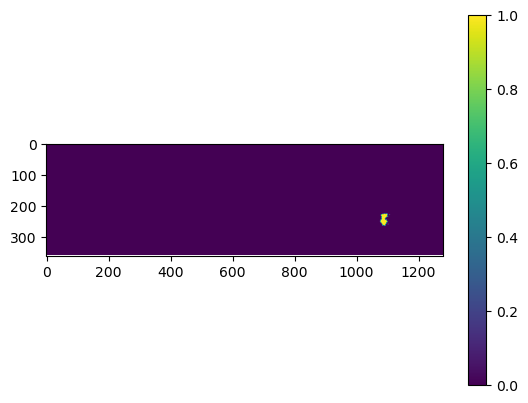

In [7]:
plt.imshow(processed_edges[0, i], cmap='viridis')  
plt.colorbar()  
plt.show()

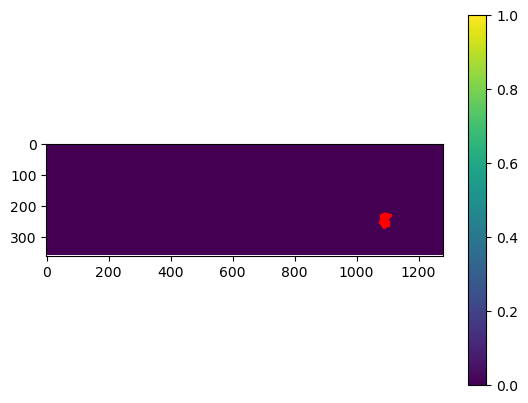

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming processed_edges[0, 30] is a 2D numpy array
# processed_edges = np.random.random((1, 31, 100, 100)) # Example data

# Extract the 2D array
data = processed_edges[0, i]

# Find indices where values are greater than 0.8
y, x = np.where(data > 0.8)

# Plot the 2D array
plt.imshow(data, cmap='viridis')
plt.colorbar()

# Overlay the points
plt.scatter(x, y, color='red', s=2)

# Show the plot
plt.show()


# 1) Input Manually 

## 1.1) Halfway Line 

In [9]:
half_line_y = 230 
# at what value do you define the halfway line between the reflection 

In [10]:
i = 200
# test a random frame 

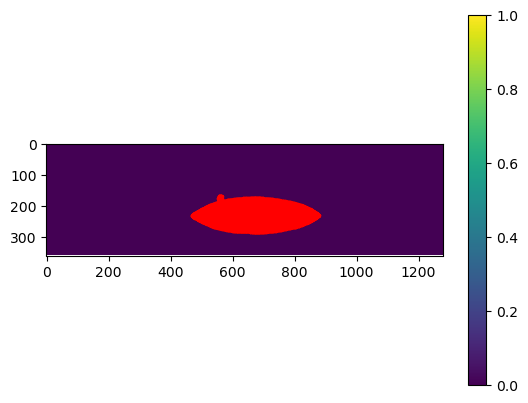

In [11]:
# Extract the 2D array
data = processed_edges[0, i]

# Find indices where values are greater than 0.8
y, x = np.where(data > 0.8)

# Plot the 2D array
plt.imshow(data, cmap='viridis')
plt.colorbar()

# Overlay the points
plt.scatter(x, y, color='red', s=2)

# Show the plot
plt.show()

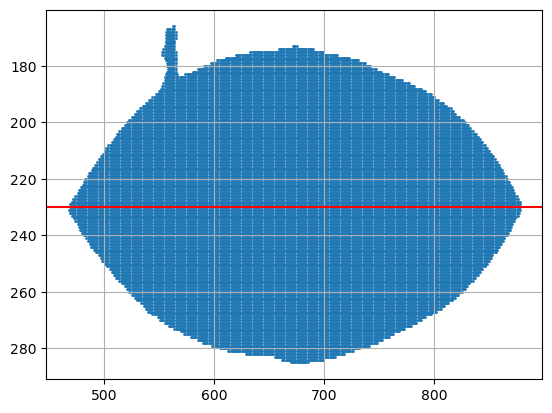

In [12]:
plt.figure()
plt.scatter(x, y, s = 1)
plt.grid(True)
plt.gca().invert_yaxis()

# Draw the horizontal line at 230
plt.axhline(y=half_line_y, color='r', linestyle='-')


#plt.ylim(400,-200)
plt.show()

# 2) Define Functions

In [13]:
def plot_extreme_x_points(x_edge, y_edge, target_y):
    """
    Plots the smallest and largest x values at target_y along with the other points.
    """
    
    # Separate points at target_y and other points
    x_at_target_y = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] == target_y]
    x_other = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]
    y_other = [y_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]

    # Find the smallest and largest x values at target_y
    if x_at_target_y:  # Ensure there's at least one point at target_y
        x_min = min(x_at_target_y)
        x_max = max(x_at_target_y)

        # Create new lists for plotting the points at target_y
        x_filtered = [x_min, x_max]
        y_filtered = [target_y, target_y]

    new_x = np.concatenate((x_filtered, x_other))
    new_y = np.concatenate((y_filtered, y_other))

    return new_x, new_y

In [14]:
def check_unique_elements(array):
    seen = set()
    non_unique = []

    for element in array:
        if element in seen:
            if element not in non_unique:
                non_unique.append(element)
        else:
            seen.add(element)

    if not non_unique:
        print("All elements are unique.")
    else:
        print("Non-unique elements:", non_unique)

# 3) Perform Loop 

In [17]:
angles_list = []

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 3000 or 230 not in y:
        pass 

    else:
        # Only consider upper half 
        x_filtered = x[y <= half_line_y]
        y_filtered = y[y <= half_line_y]

        # Find the convex hull
        points = np.vstack((x_filtered, y_filtered)).T
        hull = ConvexHull(points)

        # Detailed Convex 
        
        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T
        alpha = 0.1  
        alpha_shape = alphashape.alphashape(points, alpha)

        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy

        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        ## Now we have x_edge and y_edge which plots the edge of the shape 


        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, half_line_y)

        '''Consider only the left side Angle'''
        
        half_point = (np.min(x_main_edge) + np.max(x_main_edge)) / 2

        half_mask = [x_main_edge < half_point][0]
        x_half = x_main_edge[half_mask]
        y_half = y_main_edge[half_mask]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)

        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        # Create the interpolation function
        f = interp1d(unique_y, unique_x, kind='quadratic')

        # Generating more points for smoother interpolation
        y_curve1 = np.linspace(min(unique_y), max(unique_y), 100)
        x_curve1 = f(y_curve1)

        index_min_x = np.argmax(y_curve1)
        y_at_min_x = y_curve1[index_min_x]

        # calculate the derivative at the point
        dx_new = x_curve1[index_min_x-1] - x_curve1[index_min_x]
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)

        dy_dx = np.gradient(y_curve1, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_left = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_left<0:
            angle = np.abs(angle_tangent_degrees_left)
        
        if angle_tangent_degrees_left>0:
            angle = 180 - angle_tangent_degrees_left

        angles_list.append(angle)

100%|██████████| 543/543 [29:12<00:00,  3.23s/it]


In [20]:
angle_left = np.array(angles_list)

In [29]:
len(angle_left)

513

In [31]:
i_s = np.arange(30, 543, 1)

In [21]:
no_frames

543

In [33]:
data1 = np.column_stack((i_s, angle_left))
file_path = r"C:\Users\josep\Desktop\Summer Research Project\First_run_angle_left.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='i\tTheta')

In [34]:
file_path = r"C:\Users\josep\Desktop\Summer Research Project\First_run_angle_left.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
i = loaded_data[:, 0]
theta = loaded_data[:, 1]

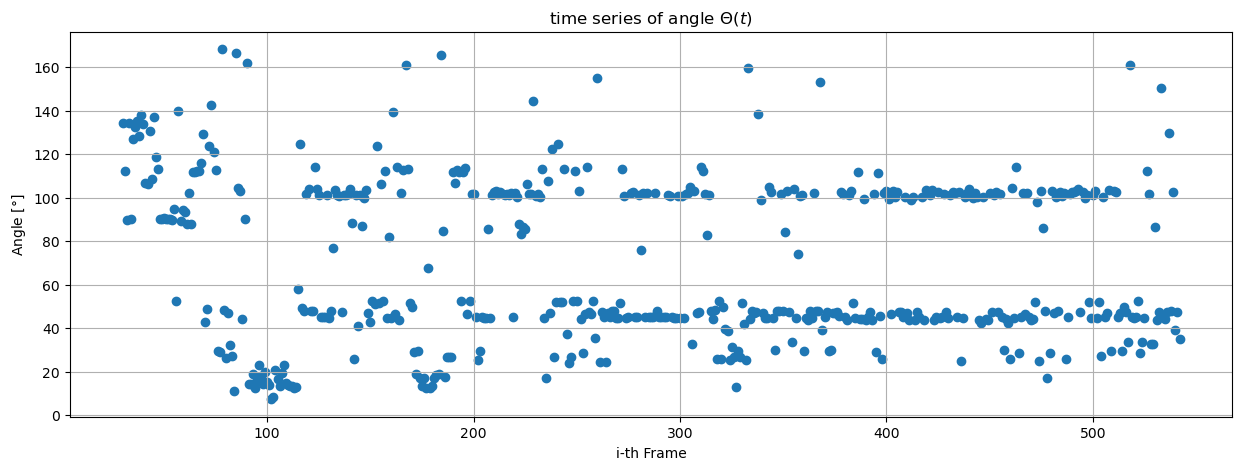

In [43]:
plt.figure(figsize=(15,5))
plt.scatter(i, theta)

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of angle $\Theta(t)$")
plt.grid(True)